# AE3: Optymalizacja wag w sieci MLP z użyciem algorytmu genetycznego
Adrianna Grudzień

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def softmax(x):
    if x.shape[1] == 1:
        return np.exp(x) / np.sum(np.exp(x))
    if x.shape[1] > 1:
        return np.exp(x) / (np.sum(np.exp(x), axis=1).reshape(
            (x.shape[0], 1)) @ np.ones((1, x.shape[1])))
    
def mean_error(y_pred_df, hot_enc_classes):
    '''Błąd klasyfikacji'''
    return np.mean(np.mean(np.abs(y_pred_df-hot_enc_classes), axis=1), axis=0)

In [3]:
class Network:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        self.mse = [] # mse


    # def feedforward0(self,x):
    #     x = np.matrix(x)
    #     for b, w in zip(self.biases, self.weights):
    #         x = sigmoid(np.dot(x,w.T)+b.T)
    #     return x
    
    def feedforward(self, x):
        x = np.matrix(x)
        for i in range(len(self.biases)-1):
            x = sigmoid(np.dot(x, self.weights[i].T)+self.biases[i].T)
        # dla ostatniej warstwy - softmax:
        i = len(self.biases)-1
        x = softmax(np.dot(x,self.weights[i].T)+self.biases[i].T)
        return x

## Zbiór `iris`

In [50]:
iris = pd.read_csv('data/iris.data', header=None)
iris.columns = ['sepal_length','sepal_width','petal_length','petal_width','class']
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [51]:
print(np.unique(iris['class']))
class_dict = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
iris_x = iris[['sepal_length','sepal_width','petal_length','petal_width']]
iris_y = iris['class'].map(class_dict) # mapowanie nazw klas w liczby

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


### One-hot encoding klas

In [21]:
def one_hot(y):
    hot_enc_classes = np.zeros(shape=(len(y),3), dtype='int')
    for i in range(len(y)):
        hot_enc_classes[i][y[i]] = 1
    return pd.DataFrame(hot_enc_classes)
hot_enc_classes = one_hot(iris_y)
hot_enc_classes.head(3)

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0


3 klasy.

In [7]:
mlp_iris = Network([4,3,3])
y_pred = mlp_iris.feedforward(iris_x)

In [8]:
y_pred_df = pd.DataFrame(y_pred)
print(y_pred_df.head(3))

mean_error(y_pred_df,hot_enc_classes)

          0         1         2
0  0.032679  0.897889  0.069432
1  0.032674  0.897922  0.069404
2  0.032669  0.897974  0.069357


0.44444600114622185

In [81]:
class AE:
    def __init__(self, N, architecture, fun):
        self.N = N
        self.architecture = architecture # architektura sieci MLP
        self.fun = fun # metryka
        self.population = [] # lista sieci
        self._initialize_population()
        
        self.new_population = copy.deepcopy(self.population) # populacja, do której będą dodawane nowe osobniki
        self.minimum_per_epoch = [] # minimalna wartość funkcji w kolejnych iteracjach

        
    def _initialize_population(self):
        for i in range(self.N):
            self.population.append(Network(self.architecture))
            
    def select_radomly_from_population(self):
        '''Losowanie dowolnego osobnika z populacji.'''
        randomNetwork = np.random.randint(self.N)
        return self.population[randomNetwork]
    
    def cross(self, prob_boundary=0.7):
        '''
        Krzyżowanie.
        - losujemy 2 sieci x1, x2 i tworzymy nowego osobnika o tej samej architekturze;
        wartości wag - z połowy wartości x1 (dla nieparzystej liczby warstw - sufit)
        oraz drugiej połowy wartości x2 (dla nieparzystej liczby warstw - podłoga)
        ''' 
        drawn_prob = np.random.uniform(0,1) # wylosowane prawdopodobieństwo krzyżowania dla danych osobników
        if drawn_prob <= prob_boundary:
            # losowanie osobników
            x1 = self.select_radomly_from_population()
            x2 = self.select_radomly_from_population()
            # określenie ile wartości z x1, x2 bierzemy do utworzenia nowego osobnika n2=len(self.architecture)-n1
            n1 = int(np.ceil((len(self.architecture)-1)/2))

            # łączenie osobników
            x_new = Network(self.architecture)
            for i in range(len(self.architecture)-1):
                if i < n1:
                    x_new.weights[i] = x1.weights[i]
                    x_new.biases[i] = x1.biases[i]
                else:
                    x_new.weights[i] = x2.weights[i]
                    x_new.biases[i] = x2.biases[i]

            # dodanie nowego osobnika do populacji
            self.new_population.append(x_new)
            
    def mutate(self, x, prob_boundary=0.2):
        '''Mutacja gaussowska - wylosowanie zgodnie z rozkładem normalnym 
        przesunięcia wag i biasów w każdym węźle
        
        x - mutowany osobnik
        prob_boundary - prawdopodobieństwo mutacji na pojedynczy osobniku (prawd. graniczne)
        '''
    
        drawn_prob = np.random.uniform(0,1) # wylosowane prawdopodobieństwo mutacji dla danego osobnika
        if drawn_prob <= prob_boundary:
            vector_displacement = np.random.normal(0, 1)
            x_new = copy.deepcopy(x)
            for i in range(len(x_new.biases)):
                x_new.weights[i] += vector_displacement
                x_new.biases[i] += vector_displacement

            # dodanie nowego osobnika do populacji
            self.new_population.append(x_new)
          
    def count_fun_values(self):
        self.fun_values = []
        for i in range(len(self.new_population)):
            self.fun_values.append(self.fun(
                self.new_population[i].feedforward(self.data_x),
                self.one_hot_classes
            ))
            
    def evaluate(self):
        '''Liczenie wartości funkcji optymalizowanej. Zwraca indeksy osobników o najniższych wartościach fun.'''
        self.count_fun_values()
        min_args = np.argpartition(self.fun_values, self.N)[:self.N]
        return min_args
        
    def select(self):
        '''Algorytm selekcji - w populacji zostawiamy self.N osobników o najniższych wartościach funkcji optymalizowanej.'''
        min_args = self.evaluate()
        self.population = [self.new_population[i] for i in min_args]
    
    def fit(self, data_x, data_y, n_epochs=10, verbose_step=10):
        self.data_x = data_x
        self.one_hot_classes = one_hot(data_y)
        
        for i in range(n_epochs):
            # krzyżowanie:
            for j in range(self.N):
                self.cross()
            # mutacja:
            for j in range(self.N):
                x = self.population[j]
                self.mutate(x)
            # selekcja
            self.select()
            
            self.minimum_per_epoch.append(np.min(self.fun_values))
            
            
    def visualize_min(self):
        plt.plot(range(1,len(self.minimum_per_epoch)+1), self.minimum_per_epoch)
        plt.xlabel('epoch number')
        plt.ylabel('minimum value of function of population')
        plt.title('Minimum value of function')
        plt.show()

In [82]:
ae = AE(N=50, architecture=[4,3,3], fun=mean_error)
ae.fit(data_x=iris_x, data_y=iris_y, n_epochs=200)

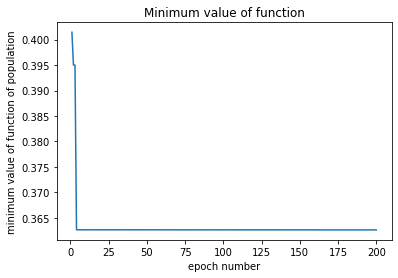

In [83]:
ae.visualize_min()

Dla epok > 10 sieć przestaje się ,,uczyć".

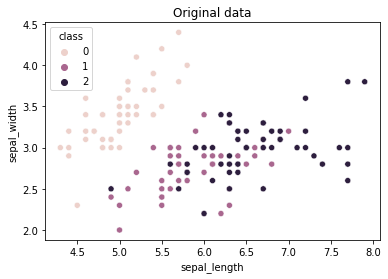

In [87]:
sns.scatterplot(x='sepal_length', y='sepal_width', data=iris, hue=iris_y)
plt.title('Original data')
plt.show()

In [85]:
y_pred_df = pd.DataFrame(ae.population[0].feedforward(iris_x))

def convert_to_classes(y_pred_df):
    pred_class = []
    for i in range(y_pred_df.shape[0]):
        pred_class.append(np.argmax(y_pred_df.iloc[i]))
    return np.array(pred_class)
pred_classes = convert_to_classes(y_pred_df)

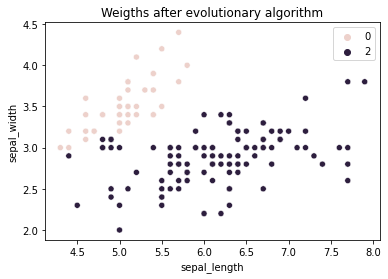

In [88]:
sns.scatterplot(x='sepal_length', y='sepal_width', data=iris, hue=pred_classes)
plt.title('Weigths after evolutionary algorithm')
plt.show()

Sieć nie rozróżnia klasy 1 i 2 - traktuje ją jako jedną. Ale rozpoznaje poprawnie klasę 0.

## Zbiór `multimodal-large`